In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: melissashort13
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification


100%|██████████| 920M/920M [00:32<00:00, 29.3MB/s]


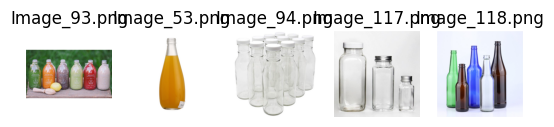

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the main images folder
image_folder = '/content/recyclable-and-household-waste-classification/images/images'

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))

# Display a few sample images
for i, image_path in enumerate(image_paths[:5]):  # Show the first 5 images
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))

plt.show()



In [5]:
import os
import shutil
import random

# Define paths
dataset_dir = '/content/recyclable-and-household-waste-classification/images/images'
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'

# Ensure train and val directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Process each class in the dataset directory
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        # Create class folders in train and val directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/val sets
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy images to train and val directories
        for image_path in train_images:
            dest_path = os.path.join(train_dir, class_name, os.path.basename(image_path))
            shutil.copyfile(image_path, dest_path)

        for image_path in val_images:
            dest_path = os.path.join(val_dir, class_name, os.path.basename(image_path))
            shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and val folders!")


Dataset successfully split into train and val folders!


In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Set up paths for train and val data
train_dir = '/content/split_dataset/train/images'
val_dir = '/content/split_dataset/val/images'

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
import os
import json
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (e.g., ResNet18)
model = models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)  # Get the number of classes from the dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [8]:
# Dataset class for .png files
class RecyclingDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, image_dir, transforms=None):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        # Ensure the file paths include the .png extension
        img_path = os.path.join(self.image_dir, annotation["image_id"] + ".png")
        img = Image.open(img_path).convert("RGB")  # Open PNG image as RGB
        boxes = torch.tensor(annotation["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotation["labels"], dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            img = self.transforms(img)

        return img, target

In [9]:
import os
import json

# Path to directory with .png images
image_dir = "/content/recyclable-and-household-waste-classification/images/images/aluminum_soda_cans/real_world"

# Example bounding box and label data (manually defined or from an annotation tool)
# Replace with real data
annotations = [
    {
        Image_1.png : "image1",  # Exclude the .png extension here
        "width": 640,
        "height": 480,
        "boxes": [[50, 30, 200, 150], [300, 100, 400, 200]],  # List of bounding boxes: [x_min, y_min, x_max, y_max]
        "labels": [1, 2]  # Corresponding class labels
    },
    {
        "": "image2",
        "width": 640,
        "height": 480,
        "boxes": [[120, 60, 220, 160]],
        "labels": [3]
    }
]

# Save annotations to JSON file
output_file = "annotations.json"
with open(output_file, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"Annotations saved to {output_file}")


NameError: name 'Image_1' is not defined

In [ ]:
# Load annotations
annotations_file = "/content/recyclable.json"
image_dir = "/path/to/images"  # Path to train/val image directory
with open(annotations_file) as f:
    annotations = json.load(f)


In [ ]:
# Split dataset into train and validation (adjust splits as needed)
train_annotations = annotations[:int(len(annotations) * 0.8)]
val_annotations = annotations[int(len(annotations) * 0.8):]

# Create train and validation datasets
train_dataset = RecyclingDataset(train_annotations, image_dir, transforms=transforms.ToTensor())
val_dataset = RecyclingDataset(val_annotations, image_dir, transforms=transforms.ToTensor())

In [ ]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Load pre-trained Faster R-CNN model and modify for custom classes
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(set([label for ann in annotations for label in ann["labels"]])) + 1  # Add 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)
model = model.to(device)

In [ ]:
# Optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [ ]:
# Evaluation and Visualization
model.eval()
for images, _ in val_loader:
    images = [img.to(device) for img in images]
    with torch.no_grad():
        predictions = model(images)

    for img, prediction in zip(images, predictions):
        img = F.to_pil_image(img.cpu())
        draw = ImageDraw.Draw(img)
        for box, label in zip(prediction["boxes"], prediction["labels"]):
            draw.rectangle(box.tolist(), outline="red", width=3)
            draw.text((box[0], box[1]), f"Class: {label.item()}", fill="white")
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        break